# ELECTRIC PRODUCTION - TIME SERIES FORECASTING USING SARIMAX

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [37]:
electric_df = pd.read_csv('/content/Electric_Production.csv')

In [38]:
electric_df.shape

(397, 2)

In [39]:
electric_df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [40]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [41]:
# changing the dtype of 'DATE'column to datetime
electric_df['DATE'] = pd.to_datetime(electric_df['DATE'])

In [42]:
electric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [43]:
# re-setting 'DATE' column as index
electric_df.set_index('DATE', inplace = True)

In [44]:
electric_df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


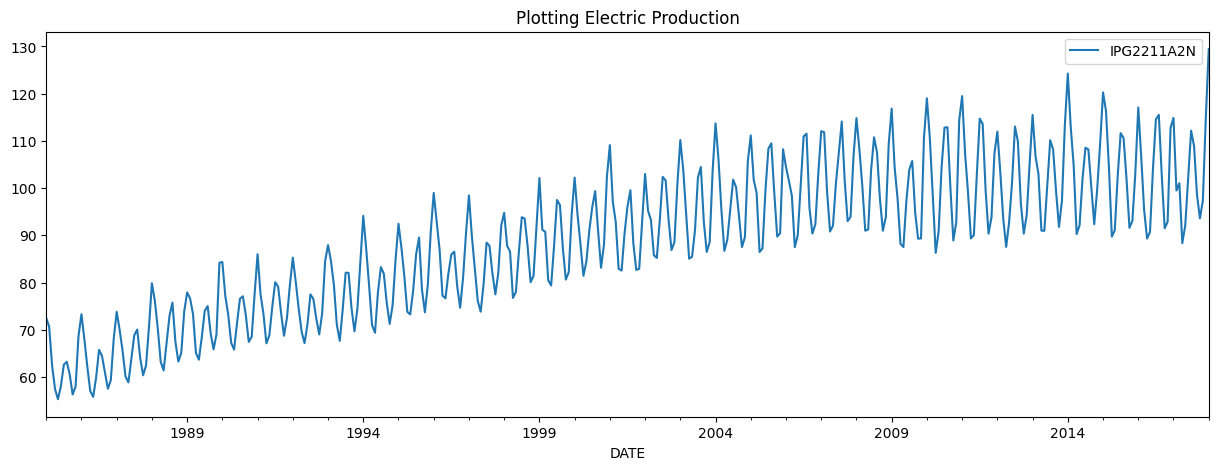

In [45]:
# plotting
electric_df.plot(figsize = (15, 5));
plt.title('Plotting Electric Production');

In [46]:
# augmented dickey fuller test

def adf_test(data):
  result = adfuller(data)
  print(f'ADF Statistic : {result[0]}')
  print(f'p-value : {result[1]}')
  if result[1] <= 0.05:
    print('Reject the Null Hypothesis - Data is Stationary')
  else:
    print('Accept the Null Hypothesis - Data is not stationary')

In [47]:
adf_test(electric_df['IPG2211A2N'])

ADF Statistic : -2.256990350047235
p-value : 0.1862146911658712
Accept the Null Hypothesis - Data is not stationary


In [48]:
# differncing
electric_df['Order_12'] = electric_df['IPG2211A2N'] - electric_df['IPG2211A2N'].shift(12)

In [49]:
electric_df.head()

,IPG2211A2N,Order_12
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN


In [50]:
adf_test(electric_df['Order_12'].dropna())

ADF Statistic : -5.673482023381762
p-value : 8.812644938088861e-07
Reject the Null Hypothesis - Data is Stationary


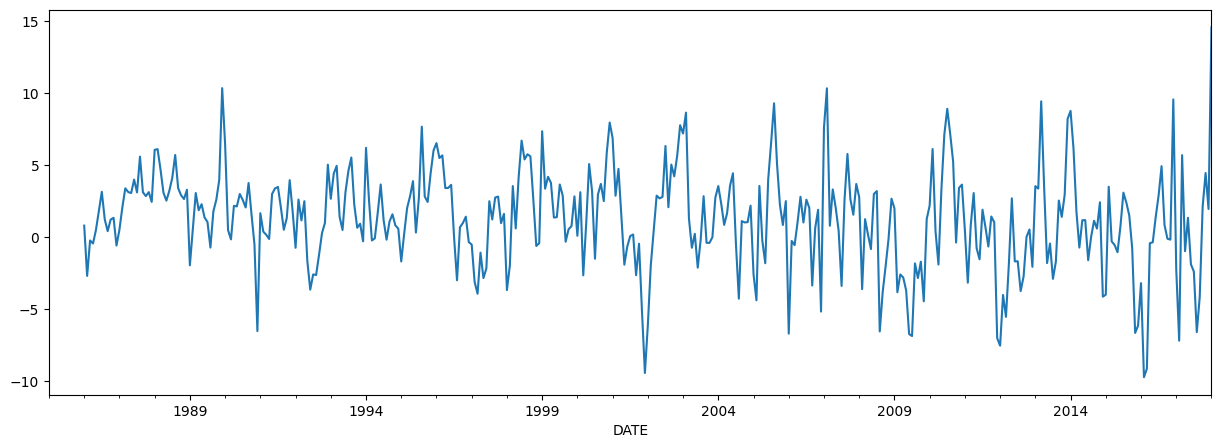

In [51]:
electric_df['Order_12'].plot(figsize = (15, 5));

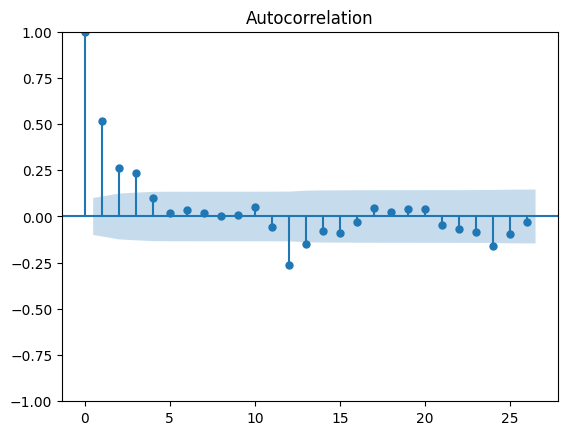

In [52]:
# acf plot
acf = plot_acf(electric_df['Order_12'].dropna())

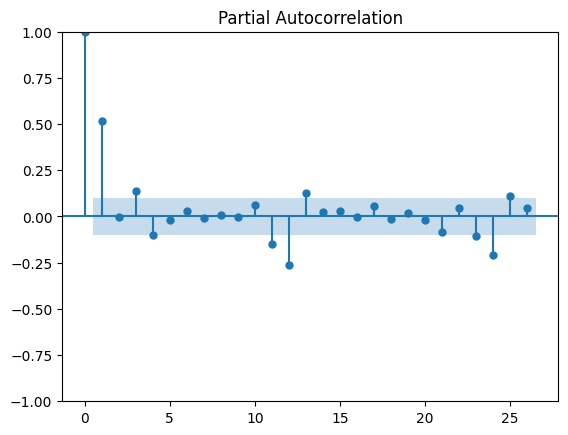

In [53]:
# pacf plot
pacf = plot_pacf(electric_df['Order_12'].dropna())

- p = 1
- d = 1
- q = 2/3

In [54]:
train = electric_df[:315]
test = electric_df[315:]

In [55]:
# Auto ARIMA to determine the best parameters
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['IPG2211A2N'], seasonal=True, m=12)

In [56]:
# Print the best parameters
print(stepwise_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -670.152
Date:                              Fri, 28 Jun 2024   AIC                           1352.305
Time:                                      05:57:45   BIC                           1374.587
Sample:                                  01-01-1985   HQIC                          1361.219
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.069      1.729      0.084      -0.016       0.254
ar.L1          0.92

In [57]:
# Fit the SARIMAX model with the best parameters from auto_arima
model = SARIMAX(train['IPG2211A2N'],
                order=stepwise_fit.order,
                seasonal_order=stepwise_fit.seasonal_order)

In [58]:
fitted_model = model.fit(disp=False)

In [59]:
print(fitted_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -673.350
Date:                              Fri, 28 Jun 2024   AIC                           1356.700
Time:                                      05:59:10   BIC                           1375.268
Sample:                                  01-01-1985   HQIC                          1364.129
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.003    345.426      0.000       0.992       1.004
ma.L1         -0.41

In [60]:
test.head()

,IPG2211A2N,Order_12
DATE,,
2011-04-01,89.3583,3.0583
2011-05-01,90.0698,-0.7666
2011-06-01,102.8204,-1.5334
2011-07-01,114.7068,1.9002
2011-08-01,113.5958,0.6944


In [63]:
pred = fitted_model.predict(start = test.index[0], end = test.index[-1])

In [64]:
test['Sarimax_pred'] = pred

In [65]:
test.head()

,IPG2211A2N,Order_12,Sarimax_pred
DATE,,,
2011-04-01,89.3583,3.0583,90.159333
2011-05-01,90.0698,-0.7666,92.056593
2011-06-01,102.8204,-1.5334,102.981221
2011-07-01,114.7068,1.9002,110.711943
2011-08-01,113.5958,0.6944,111.491746


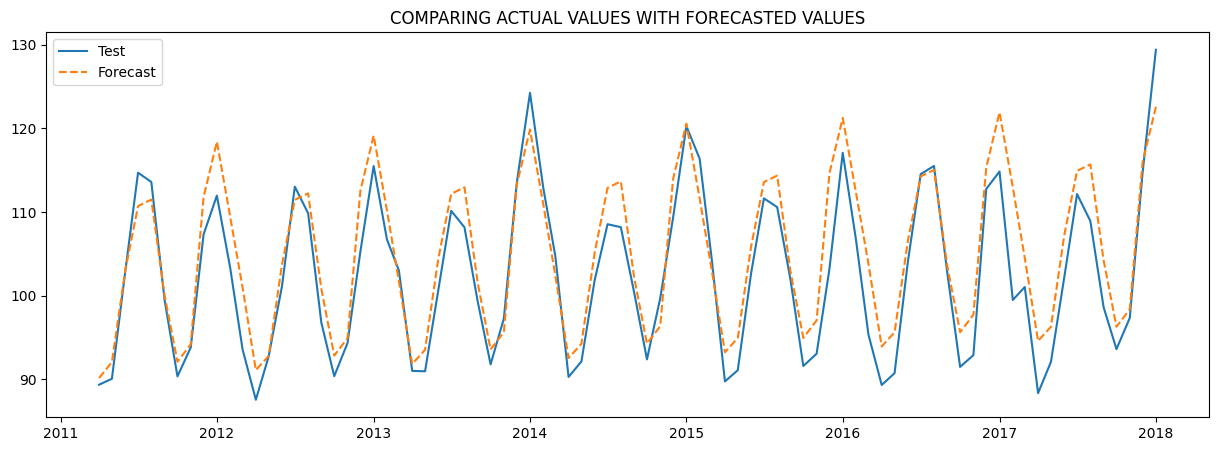

In [70]:
# Plotting actual vs forecasted values
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['IPG2211A2N'], label='Test')
plt.plot(test.index, test['Sarimax_pred'], label='Forecast', linestyle='--')
plt.title('COMPARING ACTUAL VALUES WITH FORECASTED VALUES');
plt.legend()